---
 title: A Look at the Thunder Defense
 date: 2024-02-13
 description: Looking at what makes the OKC Thunder successful on defenese
 categories: [NBA, Sports Analytics]
---

The Oklahoma City Thunder are zigging while the rest of the NBA has gone head long into their zags. 

Ever since Steph Curry and the Golden State Warriors brought on the [three-point revolution](https://en.wikipedia.org/wiki/Three-point_revolution) in the mid 2010s, NBA teams across the board have built their teams around shooting and offensive efficiency. This season, NBA teams are shooting are shooting 37.5 three-pointers per game, about 42.1% of all field goals attempted. Before the Warriors one the first championship of their eventual dynasty in 2015, those numbers were 21.5 threes attempted per game for 25.9% of their field goal attempts, and 20 years ago teams shot just 15.8 threes per game, good for just 19.7% of their total field goal attempts. With that rise in efficient shot selection, league-wide offensive efficiency numbers have improved by 7.9 points per 100 possessions.

As any good old head will tell you, though, defense wins championships. The Thunder have taken that adage to heart this year and are smothering opponents on the defensive end of the floor. The strategy has them sitting atop the Western Conference and tied for the best record in the league.

## Understanding the Three-Point Revolution

In order to understand the Thunder's response to the three-point revolution, we need to understand *why* teams started hunting these long-range shots in the first place. "But Ben, the three-point revolution is simple. Three is more than two, so it's better. Also, this is a defensive blog, why are you writing about offense?" First off, props to your math teacher. Second, mind your business, we'll get there. 

[Despite what certain former NBA players would have you believe](https://www.si.com/onsi/ball-around/news/former-all-star-guard-slams-lack-of-creativity-with-current-nba-players-01jdqg9b8bx5), the three-point revolution is not simply about taking shots that are more worth more than two-pointers. It is a response to defensive changes. In the 2000s, the NBA was all about getting your best player in a one-on-one matchup so they could drive to the hoop. Defenses started packing the paint to make those layups more difficult, freeing up perimeter shooters. Rather than taking a contested layup, teams could get better looks from three.

That doesn't mean that teams do not want layups. Layups are still the first choice for any offense. Where the real change has come is in the choice between an open mid-range shot and an open three-pointer. [Teams shoot rougly the same percentage from 10-22 feet as they do from 23 feet](https://youtu.be/hhB1vPM8ItA?si=_J52r6xdFwlPtRu8&t=168). Those 10-22 foot shots are only worth two, though, while going beyond 22' 9" is worth three. So, if you can't get a good layup, and you have a choice between a shot that is worth two and a shot that is worth three, knowing you make them at roughly the same clip, you're going to take the three. The "three-point revolution" has never been about getting rid of layups. It answers the question of, "if I can't get a good layup, what is my next best option?"

## The Thunder Make Teams Take Bad Shots

Understanding now why teams are taking and avoiding the shots they are, we can look at teams' shot selection against the Thunder.

Using the [NBA API](https://github.com/swar/nba_api/tree/master), we can pull shot location data for the NBA.

In [1]:
import pandas as pd 
import polars as pl
import nba_api.stats.endpoints as nba_endpoints
from nba_api.stats.static import teams, players
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns
import plotly.express as px

okc_id_string = "1610612760"
okc_id_int = int(okc_id_string)

# Shot data for teams against the Thunder
thunder_defensive_shot_data = nba_endpoints.ShotChartDetail(
    opponent_team_id=okc_id_string,
    team_id=0,
    player_id=0,
    context_measure_simple="FGA",
).get_data_frames()[0]

# Shot data for the whole league
league_shot_data = nba_endpoints.ShotChartDetail(
    team_id=0,
    player_id=0,
    context_measure_simple="FGA",
).get_data_frames()[0]

# Convert to Polars
thunder_defensive_shot_data = pl.from_pandas(thunder_defensive_shot_data)

league_shot_data = pl.from_pandas(league_shot_data)

# Filter out Thunder games
league_shot_data = league_shot_data.filter(
    ~pl.col("GAME_ID").is_in(thunder_defensive_shot_data['GAME_ID'])
)

In [2]:
# Get league shooting by zone
league_shooting_by_zone = league_shot_data.group_by('SHOT_ZONE_BASIC').agg(
    FGA=pl.col('SHOT_ATTEMPTED_FLAG').count(),
    FGM=pl.col('SHOT_MADE_FLAG').sum()
).with_columns([
    pl.col('FGA').alias('FGA_league'),
    pl.col('FGM').alias('FGM_league')
]).with_columns([
    (pl.col('FGM_league') / pl.col('FGA_league')).alias('fg_pct_league'),
    (pl.col('FGA_league') / 29).alias('fga_avg'),
    (pl.col('FGM_league') / 29).alias('fgm_avg')
])

# Get Thunder opponents shooting by zone
thunder_defense_by_zone = thunder_defensive_shot_data.group_by('SHOT_ZONE_BASIC').agg(
    FGA=pl.col('SHOT_ATTEMPTED_FLAG').count(),
    FGM=pl.col('SHOT_MADE_FLAG').sum()
).with_columns(
    fg_pct=pl.col('FGM') / pl.col('FGA')
).rename({'fg_pct': 'fg_pct_thunder'})

comp_df = league_shooting_by_zone.join(thunder_defense_by_zone, on='SHOT_ZONE_BASIC', how='left', suffix='_thunder').with_columns(
    fg_pct_diff = pl.col('fg_pct_league') - pl.col('fg_pct_thunder')
).sort('fg_pct_diff', descending=True)

comp_df


SHOT_ZONE_BASIC,FGA,FGM,FGA_league,FGM_league,fg_pct_league,fga_avg,fgm_avg,FGA_thunder,FGM_thunder,fg_pct_thunder,fg_pct_diff
str,u32,i64,u32,i64,f64,f64,f64,u32,i64,f64,f64
"""Left Corner 3""",7400,2839,7400,2839,0.383649,255.172414,97.896552,290,98,0.337931,0.045718
"""Above the Break 3""",42091,14883,42091,14883,0.353591,1451.413793,513.206897,1451,459,0.316334,0.037257
"""Restricted Area""",38247,25339,38247,25339,0.662509,1318.862069,873.758621,1231,771,0.62632,0.036189
"""Mid-Range""",13474,5565,13474,5565,0.413018,464.62069,191.896552,393,149,0.379135,0.033883
"""In The Paint (Non-RA)""",26946,11824,26946,11824,0.438804,929.172414,407.724138,923,386,0.418202,0.020602
"""Backcourt""",335,6,335,6,0.01791,11.551724,0.206897,13,0,0.0,0.01791
"""Right Corner 3""",6991,2715,6991,2715,0.388356,241.068966,93.62069,308,123,0.399351,-0.010994


This data frame shows us league totals for field goal shooting by zone, league averages (without the Thunder) by zone, and how teams perform against the Thunder in the same areas. I divided the league totals by 29, the number of NBA teams minus the Thunder, to get numbers for an "average" team. It is difficult to get a sense of scale when comparing league wide totals to numbers for a single team.

As we've established, teams want to get layups as frequently as possible. OKC does not allow teams to get those shots off. A typical NBA team has 1318.86 shots from within the restricted area at this point in the season, and the Thunder have allowed just 1231. And even when teams do get to the rim, they are not as effective at finishing those attempts. Teams shoot 3.6 percentage points lower at the rim against the Thunder than they do against the rest of the league.

So, if the secondary option is to shoot threes, a follow up question is, "what kind of three is best?" NBA analytics people will tell you that the corner three is the best three to take. The corner three is about a foot and a half closer to the basket than the rest of the arc, so teams prefer to take those if they can get them. What is shocking here is that the Thunder actually allow far more corner threes than league average, giving up 290 from the left corner and 308 from the right corner. Teams do shoot about 1.1 percentage points better than average from the right corner, but **4.6 percentage points worse than average from the left corner**.

How is this possible?

In [3]:
league_hustle_data = nba_endpoints.LeagueHustleStatsTeam(
    per_mode_time = "PerGame",
    team_id_nullable = None
)

league_hustle_data = league_hustle_data.get_data_frames()[0]

league_hustle_data = pl.from_pandas(league_hustle_data)

thunder_hustle_data = league_hustle_data.filter(
    pl.col("TEAM_ID") == okc_id_int
)

league_hustle_data = league_hustle_data.filter(
    pl.col("TEAM_ID") != okc_id_int
)

league_box_data = nba_endpoints.LeagueDashPtTeamDefend(
    defense_category = "3 Pointers",
    per_mode_simple = "PerGame",
    team_id_nullable = None
)

league_box_data = league_box_data.get_data_frames()[0]

league_box_data = pl.from_pandas(league_box_data)

thunder_box_data = league_box_data.filter(
    pl.col("TEAM_ID") == okc_id_int
)

league_box_data = league_box_data.filter(
    pl.col("TEAM_ID") != okc_id_int
)

hustle_box_data = league_hustle_data.join(league_box_data, on='TEAM_ID', how='left').with_columns(
    uncontested_threes_per_game = pl.col('FG3A') - pl.col('CONTESTED_SHOTS_3PT')
).with_columns(
    pct_uncontested_threes = pl.col('uncontested_threes_per_game') / pl.col('FG3A')
)

thunder_hustle_box_data = thunder_hustle_data.join(thunder_box_data, on='TEAM_ID', how='left').with_columns(
    uncontested_threes_per_game = pl.col('FG3A') - pl.col('CONTESTED_SHOTS_3PT')
).with_columns(
    pct_uncontested_threes = pl.col('uncontested_threes_per_game') / pl.col('FG3A')
)


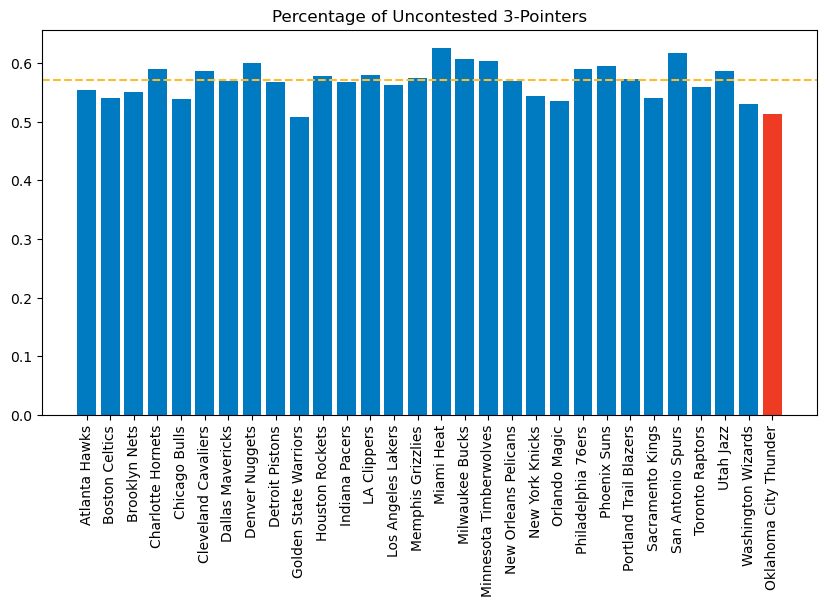

In [4]:
thunder_blue = "#007ac1"
thunder_orange = "#ef3b24"
thunder_yellow = "#fdbb30"

plt.figure(figsize=(10,5))
plt.title('Percentage of Uncontested 3-Pointers')
plt.bar(hustle_box_data['TEAM_NAME'], hustle_box_data['pct_uncontested_threes'], color=thunder_blue)
plt.bar(thunder_hustle_box_data['TEAM_NAME'], thunder_hustle_box_data['pct_uncontested_threes'], color=thunder_orange)
plt.axhline(y=hustle_box_data['pct_uncontested_threes'].mean(), color=thunder_yellow, linestyle='--', label='League Average')
plt.xticks(rotation=90)
plt.show()

In [5]:
scatter_data = pl.concat([hustle_box_data, thunder_hustle_box_data])

scatter_data = scatter_data.with_columns(
    pl.lit("Other").alias("team_group")  # First create column with all "Other"
)

# Then update just the Thunder rows
scatter_data = scatter_data.with_columns(
    pl.when(pl.col("TEAM_NAME") == "Oklahoma City Thunder")
    .then(pl.lit("Thunder"))
    .otherwise(pl.col("team_group"))
    .alias("team_group")
)

fig = px.scatter(
    data_frame=scatter_data,
    x='FG3A',
    y='pct_uncontested_threes',
    hover_data=['TEAM_NAME'],
    color='team_group',
    color_discrete_map={
        'Thunder': thunder_orange,
        'Other' : thunder_blue
    },

)

fig.update_layout(
    title='Three Point Attempts vs Uncontested Percentage',
    xaxis_title='Opponent Three Point Attempts per Game',
    yaxis_title='Percentage of Uncontested 3s',
    showlegend=False,
    yaxis=dict(
        tickformat='.1%'
    )
)

fig.show()


Well, while the Thunder do allow a fair amount of threes, they don't give up very many uncontested looks. OKC ranks second in the league for lowest percent of open three-point looks allowed, with only 51.4% of three point attempts being uncontested. Only Golden State are better at 50.8%, and the league average sits at 57%. 

For me, this begs the question of, "if I am getting contested looks from deep and contested looks at the rim, why would I not just try the contested looks at the rim?"

The data tells me that are two reasons. 

The first is chaos.

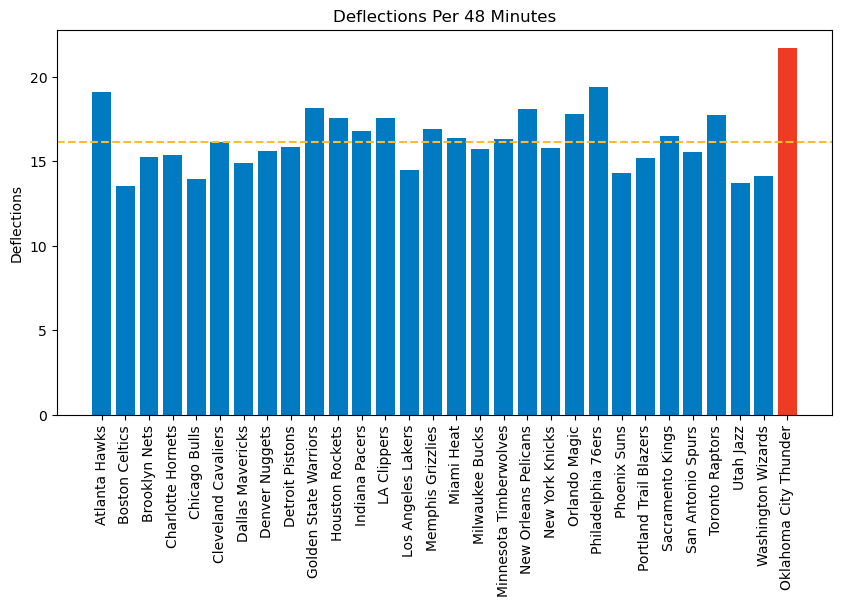

In [6]:
plt.figure(figsize=(10, 5))
plt.title('Deflections Per 48 Minutes')
plt.bar(league_hustle_data['TEAM_NAME'], league_hustle_data['DEFLECTIONS'], color=thunder_blue)
plt.bar(thunder_hustle_data['TEAM_NAME'], thunder_hustle_data['DEFLECTIONS'], color=thunder_orange)
plt.axhline(league_hustle_data['DEFLECTIONS'].mean(), linestyle="--", color=thunder_yellow)
plt.ylabel('Deflections')
plt.xticks(rotation=90)
plt.show()

OKC tip more balls than any other team in the league at 21.69 per 48 minutes, causing chaos when a team is trying to set up their offense. League average is 16.14.

Consider a normal, uneventful NBA possession after a made shot. 24 seconds on the shot clock. The team inbounds the ball and brings the ball up the floor. 19 seconds on the shot clock. The point guard initiates the offensive play and the first option isn't open. That's okay, you still have 12 or 13 seconds on the shot clock. The offense rotates the ball, drives and kicks for an open jump shot. Whether they make or miss that shot isn't relevant for our purposes, but they likely get that shot off with at least 5 seconds left on the shot clock.

Now consider what happens against the Thunder.

The same inbound and walking of the ball up the court occurs. The point guard initiates the offense but the first pass is tipped. Now you have tos scramble to recover the ball, reset, and get back into an offensive set. Let's say it takes 5 seconds to recover the ball and reset the offense. Now you aren't even getting into an offensive set until about 14 seconds on the clock. If that first option isn't open, there is very little time to rotate the ball, drive, and get a good shot off. The chaos of tipped balls doesn't allow for teams to work for a better shot. After spending the time to get the ball back, teams just need to get a shot, any shot, up before the shot clock expires.

What's more is that the Thunder are very good at recovering those loose balls when they do get deflections.

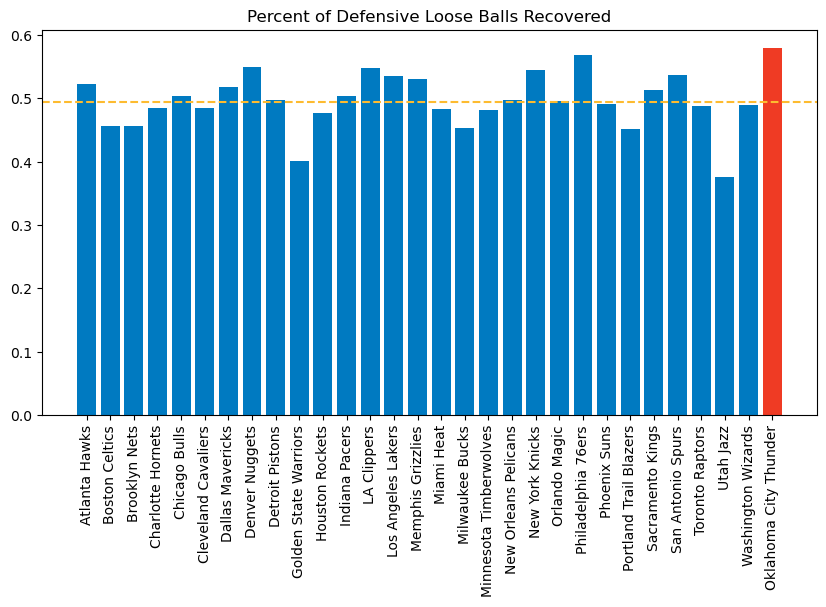

In [7]:
plt.figure(figsize=(10,5))
plt.bar(league_hustle_data['TEAM_NAME'], league_hustle_data['PCT_LOOSE_BALLS_RECOVERED_DEF'], color=thunder_blue)
plt.bar(thunder_hustle_data['TEAM_NAME'], thunder_hustle_data['PCT_LOOSE_BALLS_RECOVERED_DEF'], color=thunder_orange)
plt.title("Percent of Defensive Loose Balls Recovered")
plt.axhline(league_hustle_data['PCT_LOOSE_BALLS_RECOVERED_DEF'].mean(), linestyle="--", color = thunder_yellow)
plt.xticks(rotation=90)
plt.show()

The Thunder lead the NBA in this statistic as well, recovering 57.9% of loose balls on their defensive end of the floor. League average for this category is just 49.4%.

I almost feel bad for the Thunder opponents.

I remember growing up on the playground and playing Monkey in the Middle. There would always be one kid who was just bigger, faster, and more athletic than the rest of us. Whenever he would be the Monkey, it wasn't even fun because he would just intercept the first pass the rest of us threw.

Here are these grown men, professional athletes at the peak of their craft, just trying to play a basketball game. And the Thunder simply will not let them.

The second reason why teams might be hesitant to go at the rim is that OKC take charges better than anyone else in the league. 

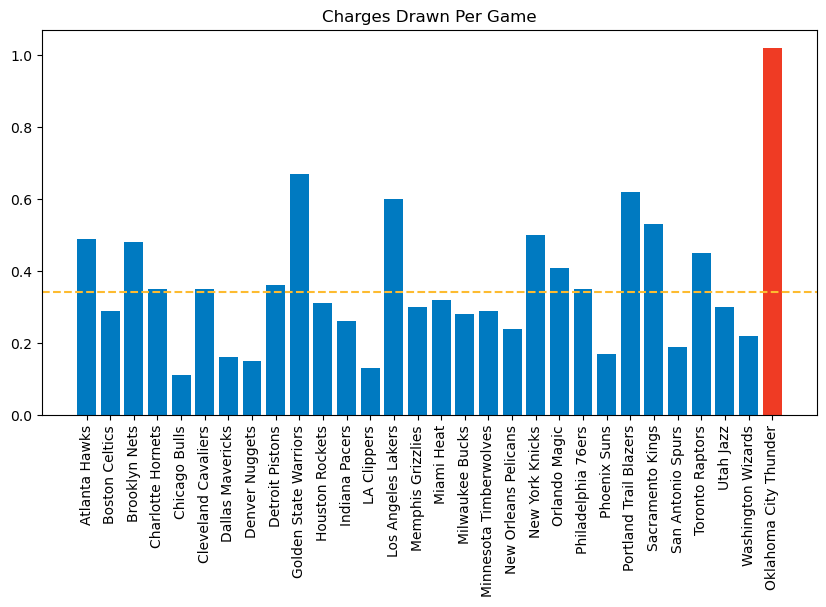

In [8]:
plt.figure(figsize=(10,5))
plt.bar(league_hustle_data['TEAM_NAME'], league_hustle_data['CHARGES_DRAWN'], color=thunder_blue)
plt.bar(thunder_hustle_data['TEAM_NAME'], thunder_hustle_data['CHARGES_DRAWN'], color=thunder_orange)
plt.axhline(league_hustle_data['CHARGES_DRAWN'].mean(), linestyle = "--", color=thunder_yellow)
plt.title("Charges Drawn Per Game")
plt.xticks(rotation=90)
plt.show()

This plot is a bit mind bending to look at. The Thunder draw, on average, 1.02 charges per game! The rest of the league averages just over one **every three games**, with the league-wide average at 0.34 charges per game.

This Z-Test visualization really demonstrates just how great the Thunder are in this regard.

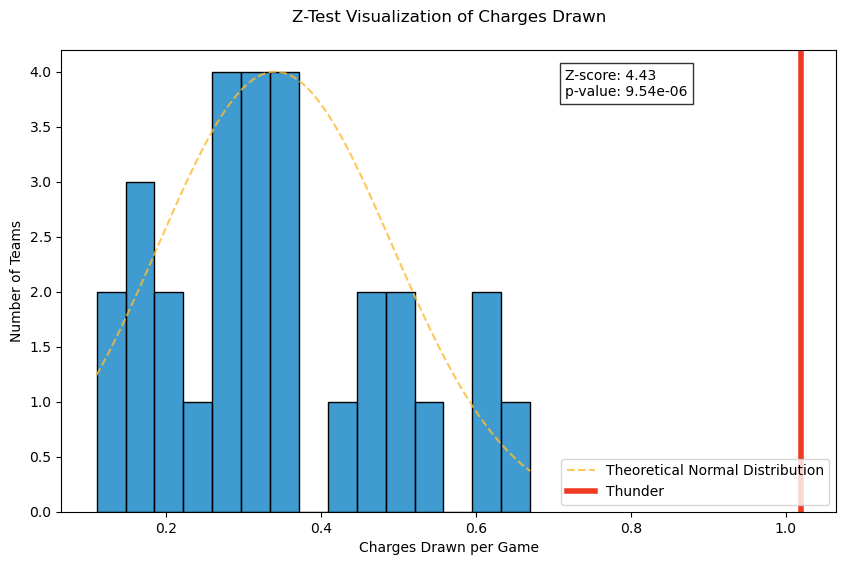

In [9]:
from statsmodels.stats.weightstats import ztest
from scipy.stats import norm
import numpy as np

ztest_score, p_val = ztest(thunder_hustle_data['CHARGES_DRAWN'], league_hustle_data['CHARGES_DRAWN'])

# Get mean and stdev
mean = league_hustle_data['CHARGES_DRAWN'].mean()
std = league_hustle_data['CHARGES_DRAWN'].std()

# Create points for the normal distribution curve
x = np.linspace(league_hustle_data['CHARGES_DRAWN'].min(), league_hustle_data['CHARGES_DRAWN'].max(), 100)
y = norm.pdf(x, mean, std)

# Scale the bell curve to martch dist
hist_heights, _ = np.histogram(league_hustle_data['CHARGES_DRAWN'], bins=15)
scaling_factor = max(hist_heights) / max(y)
y = y * scaling_factor

plt.figure(figsize=(10, 6))
sns.histplot(data=league_hustle_data['CHARGES_DRAWN'], bins=15, color=thunder_blue)
plt.plot(x, y, color=thunder_yellow, linestyle='--', alpha=0.8, label='Theoretical Normal Distribution')
plt.axvline(thunder_hustle_data['CHARGES_DRAWN'][0], color=thunder_orange, linewidth=4, label='Thunder')

plt.title('Z-Test Visualization of Charges Drawn', pad=20)
plt.xlabel('Charges Drawn per Game')
plt.ylabel('Number of Teams')
plt.legend()

# Add annotation showing z-score
plt.annotate(f'Z-score: {ztest_score:.2f}\np-value: {p_val:.2e}',
            xy=(.65, .9), xycoords='axes fraction',
            bbox=dict(facecolor='white', alpha=0.8))

plt.show()

That is a monstorous gap between Oklahoma City and the rest of the NBA. It's really impossible to overstate just how good the Thunder are at drawing offensive fouls.

## Conclusion

Oklahoma City are bucking the trend of the rest of the NBA right now - focusing in on defense while the rest of the league is trying to optimize their offenses.

The Thunder cause mayhem for teams just trying to get into their offense. If their opponents are fortunate enough to get a shot off, very rarely is the look what would normall be considered good. 

This team just plain hustles, and I am grateful that we have the opportunity to more deeply appreciate their greatness. In times gone by, these statistics are things that coaches would harp about, but they fell into the category of "intangibles that don't show up in the box score". Today, they do show up. Not just in boxscores, but in the win/loss columns and this effort has the Thunder in prime position to make a run at an NBA championship. 